In [15]:
%matplotlib notebook
import json
import numpy as np
import os
import pandas as pd
import sys
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import time, datetime, math
import seaborn as sns

DATA_DIR = 'data/blockchain/bitcoin/'
SAVE_TO = 'data/blockchain/'

def print_time(unix, str=''):
    print(str, time.ctime(int(unix)))
    
def get_readable_time(unix):
    return [time.ctime(int(u)) for u in unix]

def to_timestamp(dates):
    try:
        return [int(time.mktime(datetime.datetime.strptime(s, "%Y-%m-%d %H:%M:%S").timetuple())) for s in dates]
    except:
        print('Problem with dates', dates[1])

#236422 entries
def expand_blockchain_data(dataframe, period=300):
    #start_date = 1451609700
    #end_date = 1530385200 #1522536000 + 1
    start_date = 1451606400 #2016-01-01 00:00:00
    end_date = 1530403200 #2018-07-01 00:00:00
    interval = math.ceil((end_date - start_date)/period)
    print('interval', interval)
    dataframe = dataframe.query('date >= @start_date - 82000 & date <= @end_date').reset_index(drop=True)
    #print(dataframe.info())
    
    dataframe['round_interval'] = False
    for row in dataframe.itertuples():
        if row[1]%period == 0: #row[2] is date 
            dataframe.set_value(row[0], 'round_interval', True) #row[0] is index of the row
    
    print(interval)
    interpolated = pd.DataFrame(index=range(0,interval),columns=list(dataframe.columns.values))
    interpolated['date'] = pd.Series(np.arange(start_date,end_date,period))
    interpolated['round_interval'] = True
    #print(interpolated['date'].count)
    interpolated = interpolated.reset_index(drop=True)
    dff = pd.concat([interpolated, dataframe], axis=0).sort_values(by='date').reset_index(drop=True)
    dff = dff.interpolate(method='linear', axis=0)
    dff = dff[~dff['date'].duplicated(keep='first')].reset_index(drop=True)
    dff = dff.query('round_interval')
    del dff['round_interval']
    return dff[1:].reset_index(drop=True)

def expand_blockchain_data_eth(dataframe, period=300):
    start_date = 1451609700
    end_date = 1522536000 + 1
    interval = math.ceil((end_date - start_date)/period)
    dataframe = dataframe.query('date >= @start_date - 10000 & date <= @end_date').reset_index(drop=True)
    #print(dataframe.info())
    
    print(interval)
    interpolated = pd.DataFrame(index=range(0,interval),columns=list(dataframe.columns.values))
    interpolated['date'] = pd.Series(np.arange(start_date,end_date,period))
    #print(interpolated['date'].count)
    interpolated = interpolated.reset_index(drop=True)
    dff = pd.concat([interpolated, dataframe], axis=0).sort_values(by='date').reset_index(drop=True)
    dff = dff.astype('float64')
    dff = dff.interpolate(method='linear')
    dff = dff[~dff['date'].duplicated(keep='first')].reset_index(drop=True)
    return dff[1:].reset_index(drop=True)

def generate_blockchain_data(directory, name, timestamp_func, have_header=False):
    # should be 236422
    blockchain_df = pd.DataFrame()
    for filename in os.listdir(directory):
        column, extension = filename.split('.')
        if have_header:
            content = pd.read_csv(directory + filename, names=['date', column])[1:]
        else:
            content = pd.read_csv(directory + filename, names=['date', column], header=None) #.set_index('date')
        if blockchain_df.shape[0] < 1:
            blockchain_df = content
        else:
            blockchain_df[column] = content[column]

    blockchain_df['date'] = timestamp_func(blockchain_df['date'].values)  
    #blockchain_df.info()

    blockchain_expanded = expand_blockchain_data_eth(blockchain_df)
    blockchain_expanded[blockchain_expanded.isnull().any(axis=1)]
    blockchain_expanded.info()
    blockchain_expanded.to_pickle(SAVE_TO + name + '_blockchain.pkl')
    return blockchain_expanded
    

In [10]:
btc = pd.read_pickle(SAVE_TO + 'btc_combined.pkl')
del btc['date_readable']
del btc['n-transactions-total']

In [18]:
btc_expanded = expand_blockchain_data(btc, period=14400)
btc_expanded.to_pickle(SAVE_TO + 'btc_blockchain.pkl')
print('min', print_time(np.min(btc_expanded['date'])), np.min(btc_expanded['date']))
print('max', print_time(np.max(btc_expanded['date'])), np.max(btc_expanded['date']))
print(np.mean(btc_expanded['date'].diff()))

interval 5472
5472
 Fri Jan  1 05:00:00 2016
min None 1451620800
 Sat Jun 30 22:00:00 2018
max None 1530388800
14400.0


In [17]:
btc_expanded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5471 entries, 0 to 5470
Data columns (total 18 columns):
date                                               5471 non-null int64
avg-block-size                                     5471 non-null float64
cost-per-transaction                               5471 non-null float64
difficulty                                         5471 non-null float64
hash-rate                                          5471 non-null float64
market-cap                                         5471 non-null float64
median-confirmation-time                           5471 non-null float64
transaction-fees                                   5471 non-null float64
transaction-fees-usd                               5471 non-null float64
n-transactions-per-block                           5471 non-null float64
miners-revenue                                     5471 non-null float64
n-unique-addresses                                 5471 non-null float64
n-transactions     

In [85]:
eth = generate_blockchain_data('data/blockchain/ethereum/', 'eth', to_timestamp, True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 990 entries, 1 to 990
Data columns (total 23 columns):
date                                                                                    990 non-null int64
average-block-time-of-the-ethereum-network                                              990 non-null object
average-hashrate-of-the-ethereum-network                                                990 non-null object
daily-average-difficulty-of-the-ethereum-network                                        990 non-null object
daily-number-of-blocks-mined-by-the-ethereum-network                                    990 non-null object
daily-number-of-uncles-mined-by-the-ethereum-network                                    990 non-null object
evolution-of-the-average-block-gas-limit                                                990 non-null object
evolution-of-the-average-block-gas-usage                                                990 non-null object
evolution-of-the-average-size-of

In [74]:
path = 'data/blockchain/ethereum/'
df = pd.DataFrame()
for filename in os.listdir(path):
        column, extension = filename.split('.')
        content = pd.read_csv(path + filename, names=['date', column])[1:]
        if df.shape[0] < 1:
            print('<1')
            df = content
        else:
            print('>1')
            df[column] = content[column]
        #print(content.head(5))

print(df.info())

<1
>1
>1
>1
>1
>1
>1
>1
>1
>1
>1
>1
>1
>1
>1
>1
>1
>1
>1
>1
>1
>1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 990 entries, 1 to 990
Data columns (total 23 columns):
date                                                                                    990 non-null object
average-block-time-of-the-ethereum-network                                              990 non-null object
average-hashrate-of-the-ethereum-network                                                990 non-null object
daily-average-difficulty-of-the-ethereum-network                                        990 non-null object
daily-number-of-blocks-mined-by-the-ethereum-network                                    990 non-null object
daily-number-of-uncles-mined-by-the-ethereum-network                                    990 non-null object
evolution-of-the-average-block-gas-limit                                                990 non-null object
evolution-of-the-average-block-gas-usage                                 

In [3]:
#s = "01/12/2011"
s = '2016-01-01 00:00:00'
s = '2018-07-01 00:00:00'
int(time.mktime(datetime.datetime.strptime(s, "%Y-%m-%d %H:%M:%S").timetuple()))

1530396000

 Tue Jun 19 08:59:02 2018


In [92]:
# should be 236422
blockchain_df = pd.DataFrame()
for filename in os.listdir(DATA_DIR):
    column = filename.split('.')[0]
    if filename.split('.')[1] == 'pkl':
        break
    #print(column)
    content = pd.read_csv(DATA_DIR + filename, names=['date', column], header=None) #.set_index('date')
    #print(content.tail())
    if blockchain_df.shape[0] < 1:
        blockchain_df = content
    else:
        blockchain_df[column] = content[column]
    #break
    
blockchain_df['date'] = to_timestamp(blockchain_df['date'].values)  

blockchain_expanded = expand_blockchain_data(blockchain_df)
blockchain_expanded[blockchain_expanded.isnull().any(axis=1)]
blockchain_expanded.info()
blockchain_expanded.to_pickle(SAVE_TO + 'btc_blockchain.pkl')

c:\users\deyan\tf-workspace\env\lib\site-packages\ipykernel_launcher.py:38: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


236422
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236422 entries, 0 to 236421
Data columns (total 11 columns):
date                            236422 non-null int64
avg-block-size                  236422 non-null float64
cost-per-transaction-percent    236422 non-null float64
cost-per-transaction            236422 non-null float64
difficulty                      236422 non-null float64
hash-rate                       236422 non-null float64
market-cap                      236422 non-null float64
median-confirmation-time        236422 non-null float64
transaction-fees-usd            236422 non-null float64
transaction-fees                236422 non-null float64
transactions-per-second         236422 non-null float64
dtypes: float64(10), int64(1)
memory usage: 19.8 MB


In [30]:
#blockchain_expanded.query('round_interval')

In [4]:
blockchain_expanded[blockchain_expanded.isnull().any(axis=1)]

,date,avg-block-size,cost-per-transaction-percent,cost-per-transaction,difficulty,hash-rate,market-cap,median-confirmation-time,transaction-fees-usd,transaction-fees,transactions-per-second
0,1451609700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1451610000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1451610300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1451610600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1451610900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1451611200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1451611500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1451611800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1451612100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1451612400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [84]:
dff = expand_blockchain_data(blockchain_df)
btc_df[fields].to_pickle(SAVE_TO + 'BTC_SENTIMENT.pkl')

236422
<class 'pandas.core.frame.DataFrame'>
Int64Index: 236422 entries, 0 to 237242
Data columns (total 11 columns):
date                            236422 non-null int64
avg-block-size                  236156 non-null float64
cost-per-transaction-percent    236156 non-null float64
cost-per-transaction            236156 non-null float64
difficulty                      236156 non-null float64
hash-rate                       236156 non-null float64
market-cap                      236156 non-null float64
median-confirmation-time        236156 non-null float64
transaction-fees-usd            236156 non-null float64
transaction-fees                236156 non-null float64
transactions-per-second         236156 non-null float64
dtypes: float64(10), int64(1)
memory usage: 21.6 MB


In [36]:
blockchain_expanded['date'][1]
#min(blockchain_expanded['date'])
#should 1451609700
#should 1451602800

1451609700

In [43]:
blockchain_df.query('date >= 1451609700 & date <= 1522536000')

,date,avg-block-size,cost-per-transaction-percent,cost-per-transaction,difficulty,hash-rate,market-cap,median-confirmation-time,transaction-fees-usd,transaction-fees,transactions-per-second
262,1451689200,0.578475,3.264961,10.488361,1.038803e+11,7.074570e+05,6.524461e+09,10.033333,12947.008654,29.835942,2.333333
263,1451775600,0.525740,3.096218,11.375200,1.038803e+11,7.694240e+05,6.438701e+09,7.133333,10210.524418,23.849122,2.350000
264,1451862000,0.545497,2.348119,11.205646,1.038803e+11,9.036860e+05,6.513836e+09,6.383333,12575.658866,29.043092,1.983333
265,1451948400,0.649576,1.964873,9.487333,1.038803e+11,8.417189e+05,6.499048e+09,6.733333,14363.463986,33.256457,2.283333
266,1452034800,0.684647,1.594252,8.324821,1.038803e+11,7.022931e+05,6.483207e+09,9.450000,13004.265779,30.189822,2.550000
267,1452121200,0.677849,1.292932,9.269435,1.038803e+11,7.436044e+05,6.830411e+09,10.000000,15470.753989,34.098332,1.916667
268,1452207600,0.623070,1.627874,10.375979,1.038803e+11,9.036860e+05,6.731953e+09,7.216667,16001.927014,35.795291,2.600000
269,1452294000,0.606929,2.561246,10.104615,1.038803e+11,8.210632e+05,6.780576e+09,7.216667,13351.363431,29.659810,2.533333
270,1452380400,0.530182,2.231399,11.591775,1.038803e+11,8.778664e+05,6.723576e+09,6.683333,12869.742256,28.840405,2.700000
271,1452466800,0.640220,1.792541,10.652286,1.038803e+11,8.778664e+05,6.738585e+09,6.700000,15174.297184,33.938622,1.800000


<IPython.core.display.Javascript object>


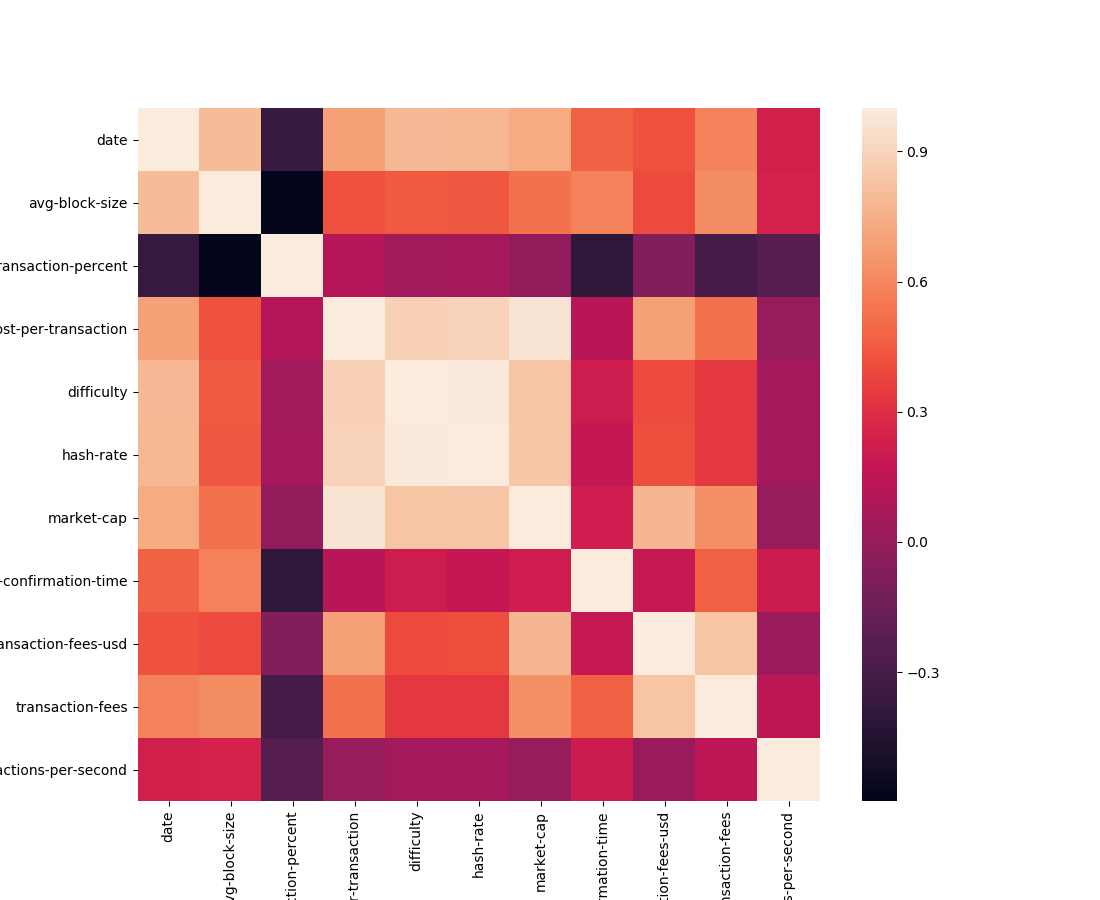

In [37]:
corrmat = blockchain_df.corr()
f, ax = plt.subplots(figsize=(11, 9))
#sns.heatmap(corrmat, vmax=.8, square=True);
sns.heatmap(corrmat)

In [24]:
blockchain_df['date'].diff().describe()

count     1094.000000
mean     86400.000000
std        266.727654
min      82800.000000
25%      86400.000000
50%      86400.000000
75%      86400.000000
max      90000.000000
Name: date, dtype: float64